# Supplementary figure (Lineage analysis)

In [1]:
experiment_ids = 'f1'
timepoints = 'all'
regions = 'cusanovich_dm6_peaks_1kb'
correction = 'wasp'

In [2]:
label = '_'.join([experiment_ids, timepoints, 'windows'])
wasp_adjusted = True if correction == 'wasp' else False

## Imports

In [3]:
# general
import sys
import os

In [4]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

from dali import run_dali
from dali.utils.stats import apply_fdr_bh

sc.settings.verbosity = 3

In [5]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [6]:
# local
sys.path.append('..')

from utils import settings

## Abbreviations

In [7]:
DALIHOM_PVAL = 'DALIHOM'
DALIHET_PVAL = 'DALIHET_VAE'
DALIHET_PVAL_LINEAGE = lambda x : 'DALIHET_TIME_%s' % x
DALIJOINT_PVAL = 'DALIJOINT'

## Plot settings

In [8]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
sns.set_style("ticks")

In [9]:
FIGURE_NUMBER = 'supp31'
PANEL_COUNTS = 1

def save_panel(fig):
    global PANEL_COUNTS
    
    fig_dir = 'figures/fig%s' % FIGURE_NUMBER
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    fig.savefig(fig_dir + '/panel_%d.svg' % PANEL_COUNTS, dpi=350)
    PANEL_COUNTS += 1

## Load anndata with GP estimates

Load total counts anndata

In [10]:
adata_total = sc.read(os.path.join(settings.DATA_DIR, label, 'total_counts_vae_processed.h5ad'))
adata_total

AnnData object with n_obs × n_vars = 34053 × 25000
    obs: 'exp_id', 'timepoint', 'n_genes', 'n_peaks_by_counts', 'log1p_n_peaks_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_peaks', 'pct_counts_in_top_100_peaks', 'pct_counts_in_top_200_peaks', 'pct_counts_in_top_500_peaks', 'n_counts', 'X_pca_0', 'size_vae', 'time_vae', 'leiden_vae', 'annotation', 'lineage_muscle', 'lineage_nervous'
    var: 'chr', 'start', 'end', 'length', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'count_variance'
    uns: 'annotation_colors', 'enrichment', 'exp_id_colors', 'leiden', 'leiden_vae_colors', 'neighbors', 'pca', 'rank_genes_groups', 'timepoint_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_vae'
    varm: 'PCs'
    layers: 'vae_peak_activities'
    obsp: 'connectivities', 'distances'

In [11]:
lineages = adata_total.obs['annotation'].cat.categories.tolist()

In [12]:
lineage_var_formatter = lambda s: dict(zip(lineages, [l.replace(' ', '_').lower() + '_%s' % s for l in lineages]))

Colors for lineages

In [13]:
lineage_colors = dict(zip(lineages, adata_total.uns['annotation_colors']))

Load anndata with GP interpolation

In [14]:
# Compile dataframe with all results
df_all = pd.DataFrame()

adatas_allelic = dict()
for exp_id in settings.F1_EXP_IDS:
    # all tested peaks
    fname = '_'.join([exp_id, regions, correction, 'allelic_counts.h5ad'])
    adata = sc.read(os.path.join(settings.DATA_DIR, label, fname))
    adata_var = adata.var
    adata_var['exp_id'] = exp_id
    adata_var['empirical_global_rate'] = (adata.X.A.sum(0) / adata.layers['allelic_total'].A.sum(0)).ravel()
    
    # compute counts per peak
    lineage_counts_df = pd.DataFrame(
        adata.layers['allelic_total'].A > 0,
        index = adata.obs_names, 
        columns = adata.var_names)
    lineage_counts_df['lineage'] = adata.obs['annotation']
    lineage_counts_df = lineage_counts_df.groupby('lineage').sum(0).T
    lineage_counts_df = lineage_counts_df.rename(lineage_var_formatter('counts'), axis=1)
    
    adata_var = pd.merge(adata_var, lineage_counts_df, left_index=True, right_index=True)
    
    # with GP estimates
    fname = '_'.join([exp_id, regions, correction, 'allelic_counts_processed.h5ad'])
    adata = sc.read(os.path.join(settings.DATA_DIR, label, fname))
    
    adata_var = pd.merge(adata_var, adata.var['qdiff_5'], left_index=True, right_index=True, how='outer', sort=False)
    
    adata_var = adata_var.reset_index().rename({'index': 'peak'}, axis=1)
    df_all = pd.concat([df_all, adata_var], ignore_index=True)
    adatas_allelic[exp_id] = adata

In [15]:
df_all

,peak,chr,start,end,length,n_cells,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,...,exp_id,empirical_global_rate,epidermis_counts,fat_body_counts,hemocytes_counts,midgut_counts,muscle_counts,nervous_system_counts,primordium_counts,qdiff_5
0,chr2L_10003721_10004721,chr2L,10003721,10004721,1001,745,745,0.123386,0.116347,92.710372,...,SS148,0.516257,79,20,38,109,212,74,213,NaN
1,chr2L_10004159_10005159,chr2L,10004159,10005159,1001,746,746,0.123386,0.116347,92.700587,...,SS148,0.517050,79,20,38,109,212,74,214,NaN
2,chr2L_10056155_10057155,chr2L,10056155,10057155,1001,1094,1094,0.178180,0.163971,89.295499,...,SS148,0.549698,102,43,37,112,296,132,372,NaN
3,chr2L_10056441_10057441,chr2L,10056441,10057441,1001,1431,1431,0.231311,0.208080,85.998043,...,SS148,0.543993,131,54,56,138,402,169,481,NaN
4,chr2L_10056861_10057861,chr2L,10056861,10057861,1001,1198,1198,0.184834,0.169602,88.277886,...,SS148,0.539439,111,43,51,110,333,145,405,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39525,chr4_66347_67347,chr4,66347,67347,1001,1093,1093,0.255395,0.227450,86.598823,...,SS159,0.508881,102,54,83,147,326,145,236,NaN
39526,chr4_66756_67756,chr4,66756,67756,1001,1139,1139,0.266184,0.236008,86.034821,...,SS159,0.507600,106,55,86,157,338,150,247,NaN
39527,chr4_68324_69324,chr4,68324,69324,1001,653,653,0.102624,0.097693,91.993624,...,SS159,0.491039,67,31,58,95,154,90,158,NaN
39528,chr4_807430_808430,chr4,807430,808430,1001,834,834,0.157430,0.146202,89.774399,...,SS159,0.522586,99,44,62,66,290,118,155,NaN


## Determine differential lineages

In [16]:
lineage_diff_pvals = pd.DataFrame()

for exp_id, adata in adatas_allelic.items():
    # only consider significantly variable peaks
    adata = adata[:, adata.var.query('%s_bh < 0.1' % DALIHET_PVAL).index]
    sub_df = pd.DataFrame(index = adata.var_names)
    for lineage in lineages:
        cell_state = pd.get_dummies(adata.obs['annotation'] == lineage)
        sub_df[lineage] = run_dali(
            A=adata.X.A, 
            D=adata.layers['allelic_total'].A, 
            cell_state=cell_state)['pvalues']
        
    sub_df = sub_df.reset_index().rename(columns={'index': 'peak'})
    sub_df['exp_id'] = exp_id
    
    lineage_diff_pvals = pd.concat([lineage_diff_pvals, sub_df])

[dali] Testing 143 regions on 1 core(s) ... 


/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
100%|██████████| 143/143 [00:05<00:00, 24.73it/s]


[dali] Testing 143 regions on 1 core(s) ... 


100%|██████████| 143/143 [00:05<00:00, 24.94it/s]


[dali] Testing 143 regions on 1 core(s) ... 


100%|██████████| 143/143 [00:05<00:00, 24.92it/s]

[dali] Testing 143 regions on 1 core(s) ... 



100%|██████████| 143/143 [00:05<00:00, 24.95it/s]

[dali] Testing 143 regions on 1 core(s) ... 



100%|██████████| 143/143 [00:05<00:00, 25.45it/s]


[dali] Testing 143 regions on 1 core(s) ... 


100%|██████████| 143/143 [00:05<00:00, 25.62it/s]

[dali] Testing 143 regions on 1 core(s) ... 



100%|██████████| 143/143 [00:05<00:00, 26.00it/s]


[dali] Testing 114 regions on 1 core(s) ... 


100%|██████████| 114/114 [00:03<00:00, 36.01it/s]

[dali] Testing 114 regions on 1 core(s) ... 



100%|██████████| 114/114 [00:03<00:00, 35.91it/s]

[dali] Testing 114 regions on 1 core(s) ... 



100%|██████████| 114/114 [00:03<00:00, 35.77it/s]

[dali] Testing 114 regions on 1 core(s) ... 



100%|██████████| 114/114 [00:03<00:00, 35.97it/s]

[dali] Testing 114 regions on 1 core(s) ... 



100%|██████████| 114/114 [00:03<00:00, 36.32it/s]

[dali] Testing 114 regions on 1 core(s) ... 



100%|██████████| 114/114 [00:03<00:00, 36.35it/s]

[dali] Testing 114 regions on 1 core(s) ... 



100%|██████████| 114/114 [00:03<00:00, 36.22it/s]

[dali] Testing 57 regions on 1 core(s) ... 



100%|██████████| 57/57 [00:01<00:00, 34.13it/s]

[dali] Testing 57 regions on 1 core(s) ... 



100%|██████████| 57/57 [00:01<00:00, 34.36it/s]

[dali] Testing 57 regions on 1 core(s) ... 



100%|██████████| 57/57 [00:01<00:00, 34.32it/s]

[dali] Testing 57 regions on 1 core(s) ... 



100%|██████████| 57/57 [00:01<00:00, 34.40it/s]

[dali] Testing 57 regions on 1 core(s) ... 



100%|██████████| 57/57 [00:01<00:00, 34.35it/s]

[dali] Testing 57 regions on 1 core(s) ... 



100%|██████████| 57/57 [00:01<00:00, 33.83it/s]

[dali] Testing 57 regions on 1 core(s) ... 



100%|██████████| 57/57 [00:01<00:00, 34.55it/s]


[dali] Testing 101 regions on 1 core(s) ... 


100%|██████████| 101/101 [00:02<00:00, 40.53it/s]

[dali] Testing 101 regions on 1 core(s) ... 



100%|██████████| 101/101 [00:02<00:00, 40.65it/s]

[dali] Testing 101 regions on 1 core(s) ... 



100%|██████████| 101/101 [00:02<00:00, 41.01it/s]

[dali] Testing 101 regions on 1 core(s) ... 



100%|██████████| 101/101 [00:02<00:00, 40.54it/s]

[dali] Testing 101 regions on 1 core(s) ... 



100%|██████████| 101/101 [00:02<00:00, 41.46it/s]

[dali] Testing 101 regions on 1 core(s) ... 



100%|██████████| 101/101 [00:02<00:00, 40.68it/s]

[dali] Testing 101 regions on 1 core(s) ... 



100%|██████████| 101/101 [00:02<00:00, 41.00it/s]


In [17]:
lineage_diff_pvals_adjusted = lineage_diff_pvals.copy()
lineage_diff_pvals_adjusted[lineages] = apply_fdr_bh(lineage_diff_pvals_adjusted[lineages].to_numpy().flatten()).reshape((lineage_diff_pvals.shape[0], len(lineages)))

In [18]:
df_all = pd.merge(df_all, lineage_diff_pvals.rename(lineage_var_formatter('diff_pval'), axis=1), left_on=['peak', 'exp_id'], right_on=['peak', 'exp_id'], how='outer')
df_all = pd.merge(df_all, lineage_diff_pvals_adjusted.rename(lineage_var_formatter('diff_pval_bh'), axis=1), left_on=['peak', 'exp_id'], right_on=['peak', 'exp_id'], how='outer')

In [19]:
lineage_diff_pvals_thresholded = lineage_diff_pvals_adjusted.copy()
lineage_diff_pvals_thresholded[lineages] = lineage_diff_pvals_thresholded[lineages] < .1

n_diff_by_peak = pd.DataFrame({
    'n_diff_lineages': lineage_diff_pvals_thresholded[lineages].sum(1),
    'exp_id': lineage_diff_pvals_adjusted['exp_id']
})
n_diff_by_lineage = lineage_diff_pvals_thresholded.groupby('exp_id').sum(0).drop('peak', 1).reset_index()
n_diff_by_lineage = n_diff_by_lineage.melt(id_vars=['exp_id'], var_name='Lineage', value_name='Peak count')

## Determine imbalanced lineages

In [20]:
lineage_imb_pvals = pd.DataFrame()

for exp_id, adata in adatas_allelic.items():
    # only consider significantly variable peaks
    adata = adata[:, adata.var.query('%s_bh < 0.1' % DALIHET_PVAL).index]
    sub_df = pd.DataFrame(index = adata.var_names)
    for lineage in lineages:
        lineage_ids = adata.obs['annotation'] == lineage
        A = adata[lineage_ids, :].X.A
        D = adata[lineage_ids, :].layers['allelic_total'].A
        sub_df[lineage] = run_dali(
            A=A,
            D=D,
            test='meanBB',
            base_rate=.5)['pvalues']
        
    sub_df = sub_df.reset_index().rename(columns={'index': 'peak'})
    sub_df['exp_id'] = exp_id
    
    lineage_imb_pvals = pd.concat([lineage_imb_pvals, sub_df])
    
lineage_imb_pvals = lineage_imb_pvals.reset_index(drop=True)
lineage_imb_pvals.index = lineage_imb_pvals['exp_id'] + '_' + lineage_imb_pvals['peak']

[dali] Testing 143 regions on 1 core(s) ... 


/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
 52%|█████▏    | 74/143 [00:01<00:01, 62.36it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 80%|███████▉  | 114/143 [00:01<00:00, 55.79it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 143/143 [00:02<00:00, 59.13it/s]

[dali] Testing 143 regions on 1 core(s) ... 



  6%|▋         | 9/143 [00:00<00:01, 79.62it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 41%|████▏     | 59/143 [00:00<00:01, 70.01it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 59%|█████▉    | 85/143 [00:01<00:00, 71.40it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 71%|███████▏  | 102/143 [00:01<00:00, 68.82it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 143/143 [00:02<00:00, 71.10it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
[dali] Testing 143 regions on 1 core(s) ... 



  0%|          | 0/143 [00:00<?, ?it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 13%|█▎        | 19/143 [00:00<00:01, 75.37it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 34%|███▎      | 48/143 [00:00<00:01, 67.82it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 46%|████▌     | 66/143 [00:00<00:01, 75.12it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 66%|██████▌   | 94/143 [00:01<00:00, 84.52it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 78%|███████▊  | 111/143 [00:01<00:00, 63.52it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 91%|█████████ | 130/143 [00:01<00:00, 71.17it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 143/143 [00:01<00:00, 72.24it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
[dali] Testing 143 regions on 1 core(s) ... 



 69%|██████▉   | 99/143 [00:02<00:00, 53.47it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 143/143 [00:02<00:00, 50.53it/s]


Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
[dali] Testing 143 regions on 1 core(s) ... 


100%|██████████| 143/143 [00:03<00:00, 38.20it/s]

[dali] Testing 143 regions on 1 core(s) ... 



  5%|▍         | 7/143 [00:00<00:02, 61.45it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 58%|█████▊    | 83/143 [00:01<00:01, 57.48it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 66%|██████▋   | 95/143 [00:01<00:00, 53.75it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 84%|████████▍ | 120/143 [00:02<00:00, 51.67it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 143/143 [00:02<00:00, 53.01it/s]

[dali] Testing 143 regions on 1 core(s) ... 



100%|██████████| 143/143 [00:04<00:00, 30.57it/s]


[dali] Testing 114 regions on 1 core(s) ... 


  8%|▊         | 9/114 [00:00<00:01, 81.01it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 33%|███▎      | 38/114 [00:00<00:00, 79.65it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 55%|█████▌    | 63/114 [00:00<00:00, 77.43it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 84%|████████▍ | 96/114 [00:01<00:00, 66.67it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 114/114 [00:01<00:00, 69.79it/s]


Overdispersion estimate out of bounds. Reverting to Binomial LRT.
[dali] Testing 114 regions on 1 core(s) ... 


 10%|▉         | 11/114 [00:00<00:00, 107.78it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 27%|██▋       | 31/114 [00:00<00:00, 94.34it/s] 

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdisper

 57%|█████▋    | 65/114 [00:00<00:00, 83.63it/s] 

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 89%|████████▊ | 101/114 [00:01<00:00, 75.96it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdisper

100%|██████████| 114/114 [00:01<00:00, 89.87it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
[dali] Testing 114 regions on 1 core(s) ... 



  8%|▊         | 9/114 [00:00<00:01, 84.95it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 16%|█▌        | 18/114 [00:00<00:01, 84.54it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 23%|██▎       | 26/114 [00:00<00:01, 79.94it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 28%|██▊       | 32/114 [00:00<00:01, 71.42it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 38%|███▊      | 43/114 [00:00<00:00, 77.63it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 59%|█████▉    | 67/114 [00:01<00:01, 33.46it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 80%|███████▉  | 91/114 [00:01<00:00, 52.85it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 114/114 [00:02<00:00, 50.87it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


[dali] Testing 114 regions on 1 core(s) ... 


  6%|▌         | 7/114 [00:00<00:01, 65.91it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 36%|███▌      | 41/114 [00:00<00:01, 63.64it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 73%|███████▎  | 83/114 [00:01<00:00, 64.99it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 84%|████████▍ | 96/114 [00:01<00:00, 57.55it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 114/114 [00:01<00:00, 62.52it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
[dali] Testing 114 regions on 1 core(s) ... 



 15%|█▍        | 17/114 [00:00<00:02, 46.44it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 114/114 [00:02<00:00, 42.06it/s]

[dali] Testing 114 regions on 1 core(s) ... 



  8%|▊         | 9/114 [00:00<00:01, 76.84it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 16%|█▌        | 18/114 [00:00<00:01, 79.05it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 37%|███▋      | 42/114 [00:00<00:01, 61.59it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 61%|██████    | 69/114 [00:01<00:00, 57.90it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 73%|███████▎  | 83/114 [00:01<00:00, 61.57it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 90%|█████████ | 103/114 [00:01<00:00, 53.23it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 114/114 [00:01<00:00, 57.38it/s]

[dali] Testing 114 regions on 1 core(s) ... 



  5%|▌         | 6/114 [00:00<00:02, 52.45it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 65%|██████▍   | 74/114 [00:01<00:00, 47.01it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 114/114 [00:02<00:00, 50.06it/s]

[dali] Testing 57 regions on 1 core(s) ... 



 14%|█▍        | 8/57 [00:00<00:00, 77.13it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 67%|██████▋   | 38/57 [00:00<00:00, 79.46it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 57/57 [00:00<00:00, 72.71it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
[dali] Testing 57 regions on 1 core(s) ... 



  0%|          | 0/57 [00:00<?, ?it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 21%|██        | 12/57 [00:00<00:00, 119.99it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 72%|███████▏  | 41/57 [00:00<00:00, 97.24it/s] 

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 86%|████████▌ | 49/57 [00:00<00:00, 86.70it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 57/57 [00:00<00:00, 77.69it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


[dali] Testing 57 regions on 1 core(s) ... 


  9%|▉         | 5/57 [00:00<00:01, 43.87it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 28%|██▊       | 16/57 [00:00<00:00, 53.31it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 42%|████▏     | 24/57 [00:00<00:00, 58.85it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 54%|█████▍    | 31/57 [00:00<00:00, 60.37it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 57/57 [00:00<00:00, 63.59it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
[dali] Testing 57 regions on 1 core(s) ... 



 11%|█         | 6/57 [00:00<00:00, 53.11it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 37%|███▋      | 21/57 [00:00<00:00, 62.45it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 74%|███████▎  | 42/57 [00:00<00:00, 61.38it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 57/57 [00:01<00:00, 56.22it/s]

[dali] Testing 57 regions on 1 core(s) ... 



 40%|████      | 23/57 [00:00<00:00, 48.12it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 57/57 [00:01<00:00, 40.03it/s]

[dali] Testing 57 regions on 1 core(s) ... 



  9%|▉         | 5/57 [00:00<00:01, 49.87it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 75%|███████▌  | 43/57 [00:00<00:00, 62.73it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 57/57 [00:00<00:00, 57.72it/s]

[dali] Testing 57 regions on 1 core(s) ... 



100%|██████████| 57/57 [00:01<00:00, 47.35it/s]


[dali] Testing 101 regions on 1 core(s) ... 


 54%|█████▍    | 55/101 [00:00<00:00, 75.08it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 82%|████████▏ | 83/101 [00:01<00:00, 82.54it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 101/101 [00:01<00:00, 75.54it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
[dali] Testing 101 regions on 1 core(s) ... 



 11%|█         | 11/101 [00:00<00:00, 99.93it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 46%|████▌     | 46/101 [00:00<00:00, 74.14it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 77%|███████▋  | 78/101 [00:00<00:00, 87.60it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 101/101 [00:01<00:00, 79.83it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
[dali] Testing 101 regions on 1 core(s) ... 



 16%|█▌        | 16/101 [00:00<00:01, 45.75it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 47%|████▋     | 47/101 [00:00<00:00, 70.40it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 69%|██████▉   | 70/101 [00:00<00:00, 85.76it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 89%|████████▉ | 90/101 [00:00<00:00, 83.10it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 101/101 [00:01<00:00, 90.70it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
[dali] Testing 101 regions on 1 core(s) ... 



 38%|███▊      | 38/101 [00:00<00:00, 69.72it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 101/101 [00:01<00:00, 62.94it/s]

[dali] Testing 101 regions on 1 core(s) ... 



 23%|██▎       | 23/101 [00:00<00:01, 49.83it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 101/101 [00:02<00:00, 48.51it/s]

[dali] Testing 101 regions on 1 core(s) ... 



 31%|███       | 31/101 [00:00<00:00, 70.54it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.
Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 49%|████▊     | 49/101 [00:00<00:00, 77.55it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


 72%|███████▏  | 73/101 [00:01<00:00, 68.75it/s]

Overdispersion estimate out of bounds. Reverting to Binomial LRT.


100%|██████████| 101/101 [00:01<00:00, 68.49it/s]

[dali] Testing 101 regions on 1 core(s) ... 



100%|██████████| 101/101 [00:02<00:00, 48.70it/s]


In [21]:
lineage_imb_pvals_adjusted = lineage_imb_pvals.copy()
lineage_imb_pvals_adjusted[lineages] = apply_fdr_bh(lineage_imb_pvals_adjusted[lineages].to_numpy().flatten()).reshape((lineage_imb_pvals.shape[0], len(lineages)))

In [22]:
df_all = pd.merge(df_all, lineage_imb_pvals.rename(lineage_var_formatter('imb_pval'), axis=1), left_on=['peak', 'exp_id'], right_on=['peak', 'exp_id'], how='outer')
df_all = pd.merge(df_all, lineage_imb_pvals_adjusted.rename(lineage_var_formatter('imb_pval_bh'), axis=1), left_on=['peak', 'exp_id'], right_on=['peak', 'exp_id'], how='outer')

In [23]:
lineage_imb_pvals_thresholded = lineage_imb_pvals_adjusted.copy()
lineage_imb_pvals_thresholded[lineages] = lineage_imb_pvals_thresholded[lineages] < .1

n_imb_by_peak = pd.DataFrame({
    'n_imb_lineages': lineage_imb_pvals_thresholded[lineages].sum(1),
    'exp_id': lineage_imb_pvals_adjusted['exp_id']
})
n_imb_by_lineage = lineage_imb_pvals_thresholded.groupby('exp_id').sum(0).drop('peak', 1).reset_index()
n_imb_by_lineage = n_imb_by_lineage.melt(id_vars=['exp_id'], var_name='Lineage', value_name='Peak count')

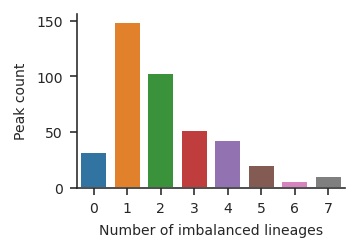

In [24]:
fig, ax = plt.subplots(figsize=(2.4, 1.6))
sns.countplot(x='n_imb_lineages', data=n_imb_by_peak, ax=ax)
ax.set(xlabel='Number of imbalanced lineages', ylabel='Peak count')
sns.despine()
save_panel(fig)

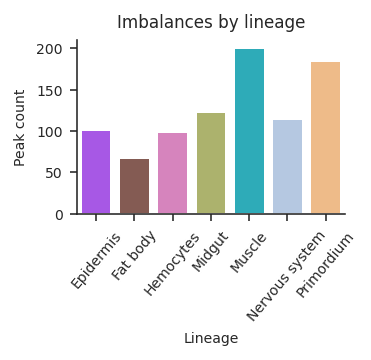

In [25]:
fig, ax = plt.subplots(figsize=(2.4, 1.6))
sns.barplot(x='Lineage', y='Peak count', data=n_imb_by_lineage.groupby('Lineage')['Peak count'].sum().reset_index(), palette=lineage_colors, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set(title='Imbalances by lineage')
sns.despine()
save_panel(fig)

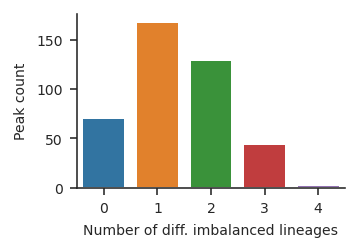

In [26]:
fig, ax = plt.subplots(figsize=(2.4, 1.6))
sns.countplot(x='n_diff_lineages', data=n_diff_by_peak, ax=ax)
ax.set(xlabel='Number of diff. imbalanced lineages', ylabel='Peak count')
sns.despine()
save_panel(fig)

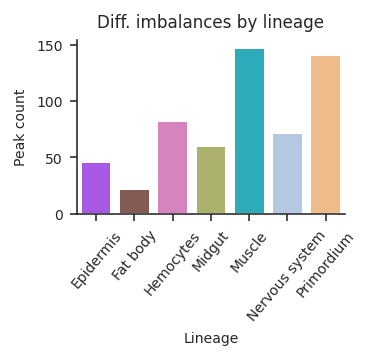

In [27]:
fig, ax = plt.subplots(figsize=(2.4, 1.6))
sns.barplot(x='Lineage', y='Peak count', data=n_diff_by_lineage.groupby('Lineage')['Peak count'].sum().reset_index(), palette=lineage_colors, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set(title='Diff. imbalances by lineage')
sns.despine()
save_panel(fig)

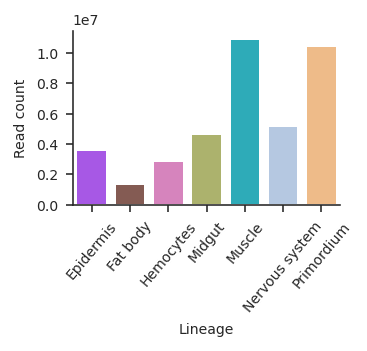

In [28]:
fig, ax = plt.subplots(figsize=(2.4, 1.6))
df_counts = (df_all[lineage_var_formatter('counts').values()]
    .rename({v: k for (k, v) in lineage_var_formatter('counts').items()}, axis=1).sum(0))
sns.barplot(x='Lineage', y='Read count', data=df_counts.reset_index().rename({'index': 'Lineage', 0: 'Read count'}, axis=1), palette=lineage_colors)
ax.set(xlabel='Lineage', ylabel='Read count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
sns.despine()
save_panel(fig)

In [34]:
n_diff_by_peak['n_diff_lineages'].value_counts()

1    168
2    129
0     71
3     44
4      3
Name: n_diff_lineages, dtype: int64

In [35]:
n_diff_by_peak['n_diff_lineages'].size

415

In [39]:
(129 + 44 + 3) / 415

0.42409638554216866

In [38]:
44 + 3

47

In [42]:
peak = 'chr2R_13675707_13676707'
lineage_diff_pvals_adjusted.query('peak == @peak')

,peak,Epidermis,Fat body,Hemocytes,Midgut,Muscle,Nervous system,Primordium,exp_id
33,chr2R_13675707_13676707,0.648712,0.344952,0.340420,0.391979,0.178067,2.814893e-07,0.008116,SS157
16,chr2R_13675707_13676707,0.148699,0.867652,0.815044,0.727584,0.045437,1.779216e-02,0.685151,SS158
